In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares
from scipy import interpolate

#ignore warning
import warnings
warnings.filterwarnings("ignore")

In [17]:
#get the price and other parameters, to find sigma
def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

#this function is to find impliedVolatility
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),#here we trying to find x, x is the impliedVolatility
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [ ]:
# def get_volatility_smile(df, exdate):#df here only contain one single expire date
#     #data wrangling

#     #given stike price, how market will pay for this option
#     df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])

#     #get strike price
#     df['strike'] = df['strike_price']*0.001

#     #get call or put label
#     df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')

#     zero_rates = pd.read_csv("zero_rates_20201201.csv")
#     interp_func = interpolate.interp1d(zero_rates["days"], zero_rates["rate"], kind='linear')

#     # # 3 maturitys pick one first 
#     # exdate = sorted(df['exdate'].unique())[0]

#     # #get specific maturity
#     # df = df[df['exdate'] == exdate]
#     #calculate how long to expire, on 1-Dec-2020
#     days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
#     #transfrom it into year
#     T = days_to_expiry/365
#     #The S&P500(SPX) index value was 3662.45 shown on slide
#     S = 3662.45
#     #we need to use "zero_rates_20201201" and apply interpolation method to get r
#     #now just an example to show, and remember divide it by 100, for now it's percentage
#     r = interp_func(days_to_expiry)/100
#     #forward price
#     F = S*np.exp(r*T)
#     #we get impliedVolatility
#     df['vols'] = df.apply(lambda x: impliedVolatility(S,
#                                                       x['strike'],
#                                                       r,
#                                                       x['mid'],
#                                                       T,
#                                                       x['payoff']),
#                           axis=1)
#     df.dropna(inplace=True)
#     #separte put and call options
#     call_df = df[df['payoff'] == 'call']
#     put_df = df[df['payoff'] == 'put']
#     #get options' strike price
#     strikes = put_df['strike'].values
#     impliedvols = []
#     for K in strikes:    
#         if K > S:
#             impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])#OTM call liqidity concern
#         else:
#             impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])#OTM put

#     #each stike has its own impliedvol when K>S is OTM call S>K is OTM put       
#     df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
#     return df

In [50]:
def market_volatility_smile(exdate, df):#this is original df
    df = df[df['exdate'] == exdate]

    #given stike price, how market will pay for this option
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])

    #get strike price
    df['strike'] = df['strike_price']*0.001

    #get call or put label
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')

    zero_rates = pd.read_csv("zero_rates_20201201.csv")
    interp_func = interpolate.interp1d(zero_rates["days"], zero_rates["rate"], kind='linear')

    # # 3 maturitys pick one first 
    # exdate = sorted(df['exdate'].unique())[0]

    # #get specific maturity
    # df = df[df['exdate'] == exdate]
    #calculate how long to expire, on 1-Dec-2020
    days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
    #transfrom it into year
    T = days_to_expiry/365
    #The S&P500(SPX) index value was 3662.45 shown on slide
    S = 3662.45
    #we need to use "zero_rates_20201201" and apply interpolation method to get r
    #now just an example to show, and remember divide it by 100, for now it's percentage
    r = interp_func(days_to_expiry)/100
    #forward price
    F = S*np.exp(r*T)
    #we get impliedVolatility
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                      x['strike'],
                                                      r,
                                                      x['mid'],
                                                      T,
                                                      x['payoff']),
                          axis=1)
    df.dropna(inplace=True)
    #separte put and call options
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    #get options' strike price
    strikes = put_df['strike'].values
    impliedvols = []
    payoffs = []
    prices = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])#OTM call liqidity concern
            prices.append(call_df[call_df['strike'] == K]["mid"].values[0])
            payoffs.append("call")
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])#OTM put
            prices.append(put_df[put_df['strike'] == K]["mid"].values[0])
            payoffs.append("put")

    #each stike has its own impliedvol when K>S is OTM call S>K is OTM put       
    df_volatility_smile = pd.DataFrame({'price': prices, 'strike': strikes, 'impliedvol': impliedvols, "payoff":payoffs})
    return df_volatility_smile

In [56]:
(pd.Timestamp(str(exdates[0])) - pd.Timestamp('2020-12-01')).days

17

In [57]:
(pd.Timestamp(str(exdates[1])) - pd.Timestamp('2020-12-01')).days

45

In [58]:
(pd.Timestamp(str(exdates[2])) - pd.Timestamp('2020-12-01')).days

80

In [59]:
df = pd.read_csv('SPX_options.csv')

# 3 maturitys
exdates = sorted(df['exdate'].unique())

mrkt_vol_smile_17 = market_volatility_smile(exdates[0], df)
mrkt_vol_smile_45 = market_volatility_smile(exdates[1], df)
mrkt_vol_smile_80 = market_volatility_smile(exdates[2], df)

In [52]:
#data wrangling
# read SPX_options
df = pd.read_csv('SPX_options.csv')

# 3 maturitys pick one first 
exdate = sorted(df['exdate'].unique())[0]

#get specific maturity
df = df[df['exdate'] == exdate]

#given stike price, how market will pay for this option
df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])

#get strike price
df['strike'] = df['strike_price']*0.001

#get call or put label
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')

zero_rates = pd.read_csv("zero_rates_20201201.csv")
interp_func = interpolate.interp1d(zero_rates["days"], zero_rates["rate"], kind='linear')

# # 3 maturitys pick one first 
# exdate = sorted(df['exdate'].unique())[0]

# #get specific maturity
# df = df[df['exdate'] == exdate]
#calculate how long to expire, on 1-Dec-2020
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
#transfrom it into year
T = days_to_expiry/365
#The S&P500(SPX) index value was 3662.45 shown on slide
S = 3662.45
#we need to use "zero_rates_20201201" and apply interpolation method to get r
#now just an example to show, and remember divide it by 100, for now it's percentage
r = interp_func(days_to_expiry)/100
#forward price
F = S*np.exp(r*T)
#we get impliedVolatility
df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
df.dropna(inplace=True)
#separte put and call options
call_df = df[df['payoff'] == 'call']
put_df = df[df['payoff'] == 'put']
#get options' strike price
strikes = put_df['strike'].values
impliedvols = []
payoffs = []
prices = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])#OTM call liqidity concern
        prices.append(call_df[call_df['strike'] == K]["mid"].values[0])
        payoffs.append("call")
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])#OTM put
        prices.append(put_df[put_df['strike'] == K]["mid"].values[0])
        payoffs.append("put")

#each stike has its own impliedvol when K>S is OTM call S>K is OTM put       
df_volatility_smile = pd.DataFrame({'price': prices, 'strike': strikes, 'impliedvol': impliedvols, "payoff":payoffs})

# 1.Displaced-diffusion model

In [18]:
def Black76Call(F_0, K, r, sigma, T):
    return BlackScholesLognormalCall(F_0*np.exp(-r*T), K, r, sigma, T)

def Black76Put(F_0, K, r, sigma, T):
    return BlackScholesLognormalPut(F_0*np.exp(-r*T), K, r, sigma, T)

def DDCall(F_0, K, r, sigma, T, beta):
    return Black76Call(F_0/beta, K+((1-beta)/beta)*F_0, r, sigma*beta, T)

def DDPut(F_0, K, r, sigma, T, beta):
    return Black76Put(F_0/beta, K+((1-beta)/beta)*F_0, r, sigma*beta, T)

def dd_cal_price(r,T,S,K,beta,sigma,payoff):
    F = S*np.exp(r*T)
    if(payoff == "call"):
        return DDCall(F,K,r, sigma, T,beta)
    else:
        return DDPut(F,K,r, sigma, T,beta)
    
#this function is to find impliedVolatility using dd model
def DD_impliedVolatility(S, K, r, price, T, payoff, beta):
    F_0 = S*np.exp(r*T)
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                DDCall(F_0, K, r, x, T, beta),#here we trying to find x, x is the impliedVolatility
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                DDPut(F_0, K, r, x, T, beta),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [12]:
#now we want to find strike closest to S = 3662.45 and its impliedvol
S = 3662.45

index = (df_volatility_smile["strike"] - S).abs().idxmin()
impliedvol = df_volatility_smile.iloc[index][1]

#then we want to use this impliedvol to calibrate dd model's beta
def dd_calibration(x, strikes, vols, S, r, T, sigma, payoffs):
    err = 0.0
    for i, vol in enumerate(vols):
        price = dd_cal_price(r, T, S, strikes.iloc[i], x[0], sigma, payoffs.iloc[i])
        err += (vol - impliedVolatility(S, strikes.iloc[i], r, price, T, payoffs.iloc[i]))**2
    return err

In [19]:
initialGuess = [0.7]
res = (
    least_squares(
        lambda x: 
        dd_calibration(
            x,
            df_volatility_smile["strike"],
            df_volatility_smile["impliedvol"],
            S,
            r,
            T,
            impliedvol,
            df_volatility_smile["payoff"]),
        initialGuess,
        bounds=(0,1)
    )
)

beta = res.x[0]

In [37]:
DD_vols = []
for i, strike in enumerate(df_volatility_smile["strike"]):
    (
        DD_vols.append(
            DD_impliedVolatility(
                S, 
                strike, 
                r,
                df_volatility_smile["price"].iloc[i],
                T, 
                df_volatility_smile["payoff"].iloc[i],
                beta
            )
        )
    )

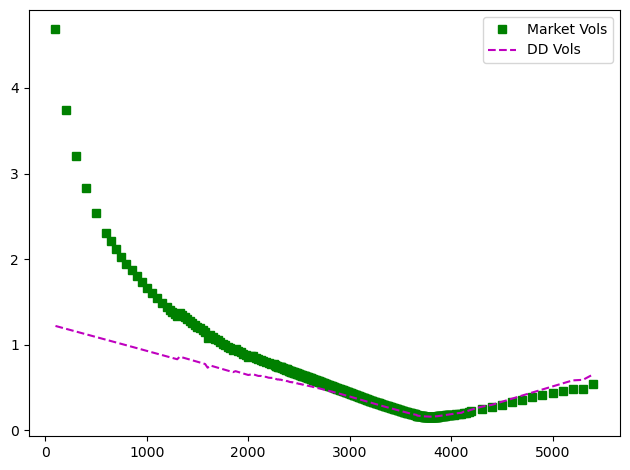

In [41]:
strikes = df_volatility_smile["strike"]

plt.figure(tight_layout=True)
plt.plot(strikes, df_volatility_smile['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, DD_vols, 'm--', label='DD Vols')
plt.legend()
plt.show()

# 2.SABR model

In [ ]:
beta = 0.7

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [ ]:
def get_sabrvols(df, exdate):
    #get specific maturity
    df = df[df['exdate'] == exdate]
    #calculate how long to expire, on 1-Dec-2020
    days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
    #transfrom it into year
    T = days_to_expiry/365
    #The S&P500(SPX) index value was 3662.45 shown on slide
    S = 3662.45
    #we need to use "zero_rates_20201201" and apply interpolation method to get r
    #now just an example to show, and remember divide it by 100, for now it's percentage
    r = interp_func(days_to_expiry)/100
    #forward price
    F = S*np.exp(r*T)
    #we get impliedVolatility
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                      x['strike'],
                                                      r,
                                                      x['mid'],
                                                      T,
                                                      x['payoff']),
                          axis=1)
    df.dropna(inplace=True)
    #separte put and call options
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    #get options' strike price
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])#OTM call liqidity concern
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])#OTM put

    #each stike has its own impliedvol when K>S is OTM call S>K is OTM put       
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

    #here we trying to figure out what is alpha, rho, nu
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)

    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    #print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

    #then we use SABR to calculate implied volitility
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    df = pd.concat([df, pd.Series(sabrvols)], axis=1)
    df.rename({0:"sabrvols"},inplace=True,axis=1)
    return df,res.x

In [ ]:
#data wrangling

# read SPX_options
df = pd.read_csv('SPX_options.csv')

#given stike price, how market will pay for this option
df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])

#get strike price
df['strike'] = df['strike_price']*0.001

#get call or put label
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')

zero_rates = pd.read_csv("zero_rates_20201201.csv")
interp_func = interpolate.interp1d(zero_rates["days"], zero_rates["rate"], kind='linear')

# 3 maturitys pick one first 
exdate = sorted(df['exdate'].unique())

In [ ]:
#alpha = res.x[0]
#rho = res.x[1]
#nu = res.x[2]
result = (
    [
        [get_sabrvols(df, exdate[0])[0],get_sabrvols(df, exdate[0])[1]],
        [get_sabrvols(df, exdate[1])[0],get_sabrvols(df, exdate[1])[1]],
        [get_sabrvols(df, exdate[2])[0],get_sabrvols(df, exdate[2])[1]]
    ])

In [ ]:
plt.figure(tight_layout=True)

plt.plot(result[0][0]["strike"], result[0][0]['impliedvol'], 'gs', label='Market Vols')
(
    plt.plot(
        result[0][0]["strike"], 
        result[0][0]["sabrvols"], 
        'r--', 
        label=f'rho={round(result[0][1][1],1)}, nu={round(result[0][1][2],1)}'
    )
)

plt.plot(result[1][0]["strike"], result[1][0]['impliedvol'], 'gs', label='Market Vols')
(
    plt.plot(
        result[1][0]["strike"], 
        result[1][0]["sabrvols"], 
        'g--', 
        label=f'rho={round(result[1][1][1],1)}, nu={round(result[1][1][2],1)}'
    )
)

plt.plot(result[2][0]["strike"], result[2][0]['impliedvol'], 'gs', label='Market Vols')
(
    plt.plot(
        result[2][0]["strike"], 
        result[2][0]["sabrvols"],
        'b--', 
        label=f'rho={round(result[2][1][1],1)}, nu={round(result[2][1][2],1)}'
    )
)


plt.legend()
plt.show()

rho is the correlation between stock and volatility, negative rho means lower the stock higher the volatility, so lower rho means more left skewness, the implied volatility should be higher. So it seems like **theory contradict with the graph**.

However as we can see higher rho has higher nu too, which means high kurtosis, that means fat tails, will increase the price then the IV, so probabily it's because **nu has much more power than rho**.